In [32]:
import pandas as pd

train_set_url = "/content/drive/MyDrive/dataset/KDDTrain_processed.csv"
test_set_url = "/content/drive/MyDrive/dataset/KDDTest_processed.csv"
train_set_url_20 = "data/KDDTrain_20%_processed.csv"
train_set_url_20_balanced = "data/KDDTrain_20%_balanced.csv"
test_set_url_20 = "data/KDDTest_for20%_processed.csv"

# Load NSL_KDD train dataset preprocessed
df_train_processed = pd.read_csv(train_set_url_20_balanced)
# Load NSL_KDD test dataset preprocessed
df_test_processed = pd.read_csv(test_set_url_20)

print(f'TRAIN SET: {df_train_processed.shape}')
print(f'TEST SET: {df_test_processed.shape}')

TRAIN SET: (67006, 118)
TEST SET: (22544, 118)


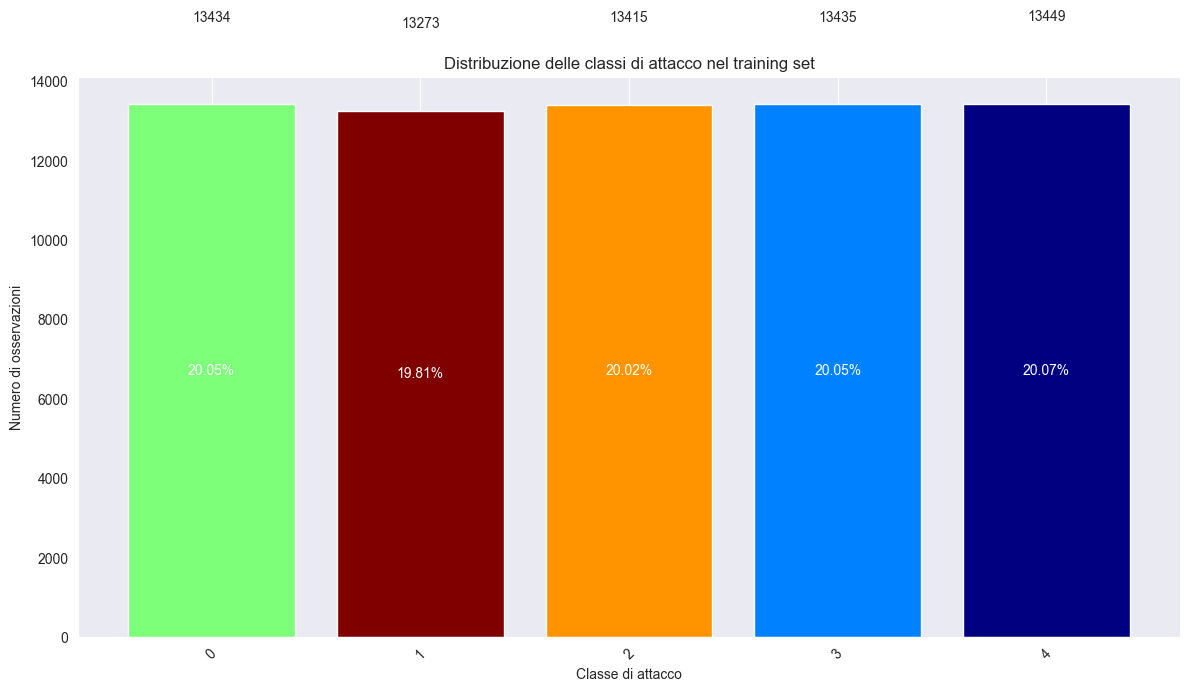

In [33]:
import Utils

# Distribuzione delle classi di Attacco nel TRAINING SET
Utils.plot_class_distribution(
    df=df_train_processed,
    column='attack_class',
    title='Distribuzione delle classi di attacco nel training set',
    xlabel='Classe di attacco',
    ylabel='Numero di osservazioni'
)

In [34]:
# Split the dataset into features and target
X = df_train_processed.drop('attack_class', axis=1)
y = df_train_processed['attack_class']

X_test = df_test_processed.drop('attack_class', axis=1)
y_test = df_test_processed['attack_class']

In [37]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.009)  # Example threshold

selector.fit(X)

X_train_reduced = selector.transform(X)
X_test_reduced = selector.transform(X_test)

print("Original feature count:", X.shape[1])
print("Reduced feature count train:", X_train_reduced.shape[1])
print("Reduced feature count test:", X_test_reduced.shape[1])

Original feature count: 117
Reduced feature count train: 53
Reduced feature count test: 53


In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the parameter grid for Random Forest and AdaBoost
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_ada = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 1]
}

# Initialize the classifiers
rf_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0, average='weighted'),
    'recall': make_scorer(recall_score, zero_division=0, average='weighted'),
    'f1': make_scorer(f1_score, zero_division=0, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', zero_division=0, average='weighted')
}

# Set up GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=kfold, scoring=scoring, refit='f1', n_jobs=-1, verbose=3)

# Set up GridSearchCV for AdaBoost
grid_search_ada = GridSearchCV(estimator=ada_clf, param_grid=param_grid_ada, cv=kfold, scoring=scoring, refit='f1', n_jobs=-1, verbose=3)


In [5]:
# Perform grid search for Random Forest
grid_search_rf.fit(X_train_reduced, y)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best scoring (F1) for Random Forest:", grid_search_rf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


D:\Progetti\ICON\NotebookICON\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best scoring (F1) for Random Forest: 0.999806011191302


In [15]:
# Perform grid search for AdaBoost
grid_search_ada.fit(X, y)
print("Best parameters for AdaBoost:", grid_search_ada.best_params_)
print("Best scoring (F1) for AdaBoost:", grid_search_ada.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


D:\Progetti\ICON\NotebookICON\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 50}
Best scoring (F1) for AdaBoost: 0.8366123807796478


In [40]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def save_feature_importances(rf_classifier, X_train, filename):
    """
    Extract and save feature importances from a Random Forest classifier.

    Parameters:
    rf_classifier (RandomForestClassifier): Trained Random Forest classifier.
    X_train (DataFrame): Training feature matrix used for the classifier.
    filename (str): Name of the file to save the feature importances.

    Returns:
    DataFrame: DataFrame containing feature importances.
    """
    feature_importances = rf_classifier.feature_importances_
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    features_df.to_csv(filename, index=True)
    return features_df

def calculate_metrics(y_true, y_pred):
    """
    Calculate and return various evaluation metrics.

    Parameters:
    y_true (Series): True labels.
    y_pred (Series): Predicted labels.

    Returns:
    dict: A dictionary containing various evaluation metrics.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0, average='weighted'),
        'recall': recall_score(y_true, y_pred, zero_division=0, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, zero_division=0, average='weighted'),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

    return metrics

def print_evaluation_metrics(evaluation_metrics):
    for metric, value in evaluation_metrics.items():
        if metric == 'confusion_matrix':
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value}")

In [39]:
# Initialize and fit the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=None, min_samples_split=10, n_estimators=200)
rf_classifier.fit(X, y)

# Making predictions
y_pred = rf_classifier.predict(X_test)

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred)
print_evaluation_metrics(evaluation_metrics)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

accuracy: 0.7551898509581263
precision: 0.8177077793617018
recall: 0.7551898509581263
f1_score: 0.7215685578845368
confusion_matrix:
[[5765 1654   39    0    0]
 [  66 9456  187    1    1]
 [ 178  740 1503    0    0]
 [   0 2451    5  296    2]
 [   0  185    8    2    5]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      7458
           1       0.65      0.97      0.78      9711
           2       0.86      0.62      0.72      2421
           3       0.99      0.11      0.19      2754
           4       0.62      0.03      0.05       200

    accuracy                           0.76     22544
   macro avg       0.82      0.50      0.52     22544
weighted avg       0.82      0.76      0.72     22544



In [41]:
# Save feature importances to CSV
feature_importances_df = save_feature_importances(rf_classifier, X, 'features_scores_RF.csv')

# Display the feature importances
print(feature_importances_df)

               Feature    Importance
1            src_bytes  8.136405e-02
2            dst_bytes  7.763013e-02
8            logged_in  6.276793e-02
28  dst_host_srv_count  4.889548e-02
18               count  4.458965e-02
..                 ...           ...
89         service_rje  7.685244e-09
16       is_host_login  0.000000e+00
98       service_tim_i  0.000000e+00
87       service_red_i  0.000000e+00
3                 land  0.000000e+00

[117 rows x 2 columns]


In [45]:
# Number of top features selected
N = 80
# Select the top N important features for training and test sets
important_features_rf = feature_importances_df.head(N)['Feature'].values

# Train a new Random Forest Classifier on the top N features
rf_important_classifier = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=None, min_samples_split=10, n_estimators=200)

# Fit the new classifier on the training data with only the top N important features
rf_important_classifier.fit(X[important_features_rf], y)

# Make predictions with the new classifier
y_pred_important_rf = rf_important_classifier.predict(X_test[important_features_rf])

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred_important_rf)
print_evaluation_metrics(evaluation_metrics)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

accuracy: 0.7494233498935415
precision: 0.814833414741685
recall: 0.7494233498935415
f1_score: 0.7100470564445128
confusion_matrix:
[[5775 1646   37    0    0]
 [  67 9457  185    0    2]
 [ 182  751 1488    0    0]
 [   0 2578    5  170    1]
 [   0  184    9    2    5]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      7458
           1       0.65      0.97      0.78      9711
           2       0.86      0.62      0.72      2421
           3       0.99      0.11      0.19      2754
           4       0.62      0.03      0.05       200

    accuracy                           0.76     22544
   macro avg       0.82      0.50      0.52     22544
weighted avg       0.82      0.76      0.72     22544



In [31]:
adabost_classifier = AdaBoostClassifier(random_state=42, learning_rate=0.1, n_estimators=50)

adabost_classifier.fit(X, y)

# Making predictions
y_pred = adabost_classifier.predict(X_test)

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred)
print_evaluation_metrics(evaluation_metrics)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

accuracy: 0.4522711142654365
precision: 0.6160674990425031
recall: 0.4522711142654365
f1_score: 0.3022640693212586
confusion_matrix:
[[  40 7410    8    0    0]
 [   0 9658   53    0    0]
 [   0 1923  498    0    0]
 [   0 2754    0    0    0]
 [   0  200    0    0    0]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.01      7458
           1       0.44      0.99      0.61      9711
           2       0.89      0.21      0.33      2421
           3       0.00      0.00      0.00      2754
           4       0.00      0.00      0.00       200

    accuracy                           0.45     22544
   macro avg       0.47      0.24      0.19     22544
weighted avg       0.62      0.45      0.30     22544



D:\Progetti\ICON\NotebookICON\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Progetti\ICON\NotebookICON\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Progetti\ICON\NotebookICON\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y) # training model on training dataset

y_pred=knn.predict(X_test)  # predicting target attribute on testing dataset

# Calculate metrics
evaluation_metrics = calculate_metrics(y_test, y_pred)
print_evaluation_metrics(evaluation_metrics)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

accuracy: 0.7513307310149042
precision: 0.8096513242318963
recall: 0.7513307310149042
f1_score: 0.7044811723941246
confusion_matrix:
[[5792 1579   86    1    0]
 [  55 9447  208    0    1]
 [ 179  579 1662    1    0]
 [   0 2664   60   30    0]
 [   0  171   22    0    7]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      7458
           1       0.65      0.97      0.78      9711
           2       0.82      0.69      0.75      2421
           3       0.94      0.01      0.02      2754
           4       0.88      0.04      0.07       200

    accuracy                           0.75     22544
   macro avg       0.85      0.50      0.50     22544
weighted avg       0.81      0.75      0.70     22544

